# Закон Кюри-Вейсса

### Оценим допустимую ЭДС

In [1]:
delta_T = 0.5
k = 24
E = delta_T/k
print(E, "мВ")

0.020833333333333332 мВ


## Исследуем зависимость периода колебаний $\tau$ от температуры $T$

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from sklearn import linear_model, metrics
from scipy.optimize import curve_fit
from scipy import interpolate

In [3]:
df = pd.read_csv('main.csv')
df['T'] = df.T_m + k*df.U
df

,t,T_s,T_m,U,T
0,10.788,14.00,14.5,-0.005,14.380
1,10.725,15.83,16.3,-0.015,15.940
2,10.573,17.87,18.6,-0.015,18.240
3,10.288,20.02,20.6,-0.014,20.264
4,9.960,21.96,22.8,-0.016,22.416
5,9.610,23.96,24.8,-0.018,24.368
6,9.428,25.95,26.9,-0.018,26.468
7,9.340,27.96,28.6,-0.017,28.192
8,9.288,29.96,30.6,-0.017,30.192
9,9.252,31.96,32.6,-0.017,32.192


In [4]:
# TODO: Поменять на экспериментальное
t0 = 9.05

In [5]:
X = np.divide(np.power(t0, 2), np.power(df.t, 2) - np.power(t0, 2))
Y = df['T']

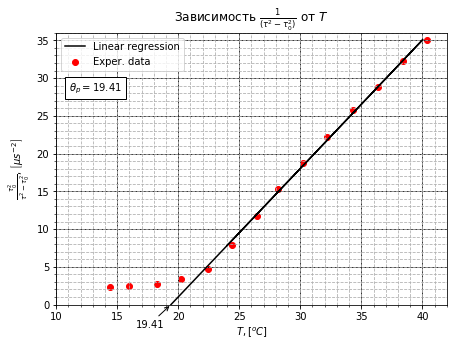

In [6]:
X_line = X[lambda x: x >= 5] # Здесь точка отброса

# Строим регрессиюц
regressor = linear_model.LinearRegression()
regressor.fit(X_line.values.reshape(-1, 1), Y[X_line.index].values.reshape(-1, 1))
Y_line = regressor.predict(X_line.values.reshape(-1, 1))
X_line = X_line.append(pd.Series([0]))
Y_line = np.append(Y_line, pd.Series(regressor.intercept_[0]))

f, ax = plt.subplots(figsize=(7, 5))
ax.scatter(Y, X, label='Exper. data', c='r')

ax.plot(Y_line, X_line, label='Linear regression', c='black')
ax.set_title(r'Зависимость $\frac{1}{(\tau^2 - \tau_0^2)}$ от $T$', y=1.02)
ax.set_ylabel(r'$\frac{\tau_0^2}{\tau^2-\tau_0^2}$, $\left[ \mu s^{-2} \right]$')
ax.set_xlabel(r'$T, [^oC]$')

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim(0, 36)
ax.set_xlim(10, 42)
#ax.set_yticks(np.append(ax.get_yticks(), [np.round(regressor.intercept_[0], 2)]))
ax.annotate(round(regressor.intercept_[0], 2), 
            xy=(regressor.intercept_[0], 0), 
            xytext=(regressor.intercept_[0]*0.85, -3),
           arrowprops={"facecolor": "black", "arrowstyle":"->"})
ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', c='black', linestyle='-')

f.text(x=0.15, y=0.72, s=r"$\theta _p = {}$".format(round(regressor.intercept_[0], 2)), bbox={"alpha": 1, "facecolor": "white"})
ax.legend()

plt.savefig('out.pdf', fmt='pdf')
plt.show(f)

In [7]:
print("Уголовой коэффициент: {} \nТочка пересечения (константный признак): {}\nСтандартное отклонение: {}".format(regressor.coef_[0][0], regressor.intercept_[0], metrics.mean_squared_error(Y[X_line.index], Y_line)))

Уголовой коэффициент: 0.5878182516011139 
Точка пересечения (константный признак): 19.40590155155477
Стандартное отклонение: 2.57840029802427


### Оригинальное T от $\tau$

In [8]:
Y_or = np.power(df.t, 2)
X_or = df['T']

In [9]:
def pol(x, w, n):
    return sum([w[n]*x**n for n in range(n+1)])
def fu(x, a, b, c): # Будем пытаться аппроксимировать гиперболой в общем виде
    return 1/(a*x+b) + c

[  1.17056011e-03   1.23730662e-17   6.01953225e+01]


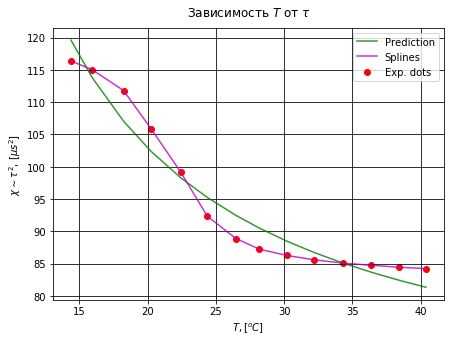

In [10]:
f, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X_or, Y_or, label="Exp. dots", c='r')
# ПОДГОНИСТАЯ АППРОКСИМАЦИЯ. ПИТОН, Я ЛЮБЛЮ ТЕБЯ
n = 1 # Отбосим первые n точек
X_or_a = X_or[n-1:]
Y_or_a = Y_or[n-1:]
popt, pcov = curve_fit(fu, X_or_a, Y_or_a, bounds=([10**(-30), 10**(-20), 40], [10**(1), 10**(1), 100]))

print(popt)
colors = ['r', 'g', 'm', 'y', 'c', 'k', 'black']
'''
best = [9]   # НЕ СПРАШИВАЙТЕ, КАК
for n in best:
    w = np.polyfit(X_or, Y_or, deg=n)
    X_or_pred = np.linspace(min(X_or)*0.999, max(X_or), 5000)
    Y_or_pred = [pol(i, w[::-1], n) for i in X_or_pred]
    ax.plot(X_or_pred, Y_or_pred, label="Prediction, n={}".format(n), c=colors[n-3], alpha=0.7)
'''
#X_or_pred = np.linspace(min(X_or)*0.999, max(X_or), 5000)
#Y_or_pred = fu(X_or_pred, *popt)
#print(Y_or_pred)
ax.plot(X_or, fu(X_or, *popt), label="Prediction", c=colors[1], alpha=0.8)

# СПЛАЙН
f_spl = interpolate.interp1d(X_or_a, Y_or_a)
ax.plot(X_or, f_spl(X_or), label="Splines", c=colors[2], alpha=0.8)

ax.set_title(r'Зависимость $T$ от $\tau$', y=1.02)
ax.set_ylabel(r'$\chi \sim \tau^2$, [$\mu s^2$]')
ax.set_xlabel(r'$T, [^oC]$')

#ax.yaxis.set_minor_locator(MultipleLocator(1))
#ax.xaxis.set_minor_locator(MultipleLocator(0.025))
#ax.set_xlim(0, 0.4)
#ax.set_yticks(np.append(ax.get_yticks(), [np.round(regressor.intercept_[0], 2)]))
ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', c='black', linestyle='-')

ax.legend()
plt.savefig('out1.pdf', fmt='pdf')
plt.show(f)